In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, OrderedDict

In [10]:
# original rgb
eurosat = pd.read_csv('../data/csv_data.csv')

# after conv layers
eurosat_resnet = pd.read_csv('../data/resnet-output.csv')

In [15]:
def data_mec(df, debug=False):

    classes = df['class'].unique()
    dims = len(df.columns) - 2 # pd index and target col
    num_rows = len(df)          
    prob_classes = df['class'].value_counts()/num_rows
    
    #calculate sum
    df['dim_sum'] = df.iloc[:,:-1].sum(axis=1)
    
    #sort by dim_sum and class
    sorted_df = df.sort_values(['dim_sum', 'class'])
    
    # find change
    c = -1 
    class_threshold = defaultdict(int)
    for label in sorted_df['class']:
        if label != c:
            c = label
            class_threshold[c] += 1
            
    # to * or not to * it is a question
    mec = math.ceil(sum([(math.ceil(math.log(class_threshold[i] + 1, 2)) * dims * prob_classes[i]) for i in classes]))
    
    return mec

In [16]:
print("\nMemory Equivalent Capacity for RGB eurosat :", data_mec(eurosat, True))
print("\nMemory Equivalent Capacity for eurosat resnet conv output :", data_mec(eurosat_resnet, True))


Memory Equivalent Capacity for RGB eurosat : 142678

Memory Equivalent Capacity for eurosat resnet conv output : 5955


<AxesSubplot:title={'center':'Capacity Progression(Algorithm 2)'}, xlabel='% Training Data', ylabel='Dataset MEC'>

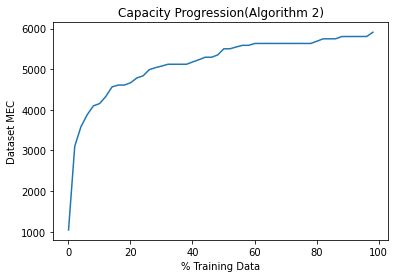

In [17]:
proportions = np.arange(0.001, 1, 0.02)
mec_list = []
for i in proportions:
    mec_list.append(data_mec(eurosat_resnet.sample(frac=i, axis=0)))
plt.title("Capacity Progression(Algorithm 2)")
plt.xlabel("% Training Data")
plt.ylabel("Dataset MEC")
sns.lineplot(x=proportions * 100, y=mec_list)

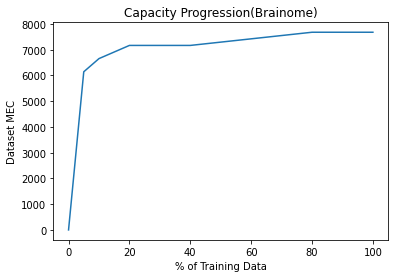

In [18]:
import matplotlib.pyplot as plt
import numpy as np

#Capacity Progression:             at [ 5%, 10%, 20%, 40%, 80%, 100% ]
#    Ideal Machine Learner:             12,  13,  14,  14,  15,  15

plt.plot([0,5,10,20,40,80,100], np.asarray([0,12,13,14,14,15,15]) * 512)
plt.title("Capacity Progression(Brainome)")
plt.xlabel("% of Training Data")
plt.ylabel("Dataset MEC");

## Visualize Results

In [2]:
# load and parse log file
import sys 
sys.path.append("..") 
from utils.log_tool import read_log

"""
Structure of res:
{MEC:{'train':[xxx], 'test':[xxx], 'val':[xxx]}, ...}

Structure of best_res:
{MEC:{'train':float, 'test':float, 'val':float}, ...}
"""

res, best_res = read_log('../log/mlp_mec_acc_eurosat_epoch20_pretrained_seed42_test20.log')

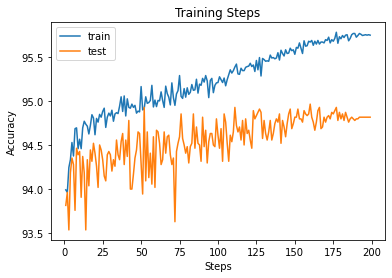

In [4]:
# Visulize Train Test Accuracy as Step increases
MEC = 8224

train_acc = res[MEC]['train']
test_acc = res[MEC]['test']
steps = [i for i in range(len(train_acc))]

plt.plot(steps[1:], train_acc[1:], label='train')
plt.plot(steps[1:], test_acc[1:], label='test')

plt.legend()
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.title('Training Steps')
plt.show()

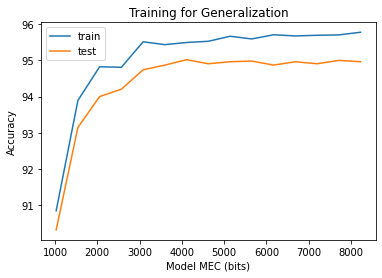

In [5]:
# Visualize for Generalization (Select hidden size from 1 to 15)

MECs = [i for i in best_res][1:16]
train_acc_mec = [best_res[i]['train'] for i in MECs]
test_acc_mec = [best_res[i]['test'] for i in MECs]

plt.plot(MECs, train_acc_mec, label='train')
plt.plot(MECs, test_acc_mec, label='test')

plt.legend()
plt.xlabel('Model MEC (bits)')
plt.ylabel('Accuracy')
plt.title('Training for Generalization')
plt.show()

## Train/ Test Generalization

In [5]:
eurosat_classes = ('AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial',
            'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake')

# calculate number of images per class in the whole dataset 
images_nums = []
for root, dirs, files in os.walk("../../294-082-final-project_old/data/2750/", topdown=False):
   for d in dirs:
       for root, dirs, files in os.walk("../../294-082-final-project_old/data/2750/"+d, topdown=False):
           images_nums.append(len(files))


In [3]:
import torch
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


linear_classifier = nn.Sequential(
    nn.Linear(512, 8),
    nn.ReLU(),
    nn.Linear(8, 10),
)

state_dict = torch.load('../trained_mlp/cnn-ckpt_fc8.pth', map_location=torch.device(device))['net']
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k[7:] # remove `module.`
    new_state_dict[name] = v
# load params
linear_classifier.load_state_dict(new_state_dict)

from dataset.eurosat_feature import get_eurosat_features_dataloader
train_dl, test_dl = get_eurosat_features_dataloader('../data/resnet-output.csv')


<AxesSubplot:title={'center':'Train set confusion matrix'}>

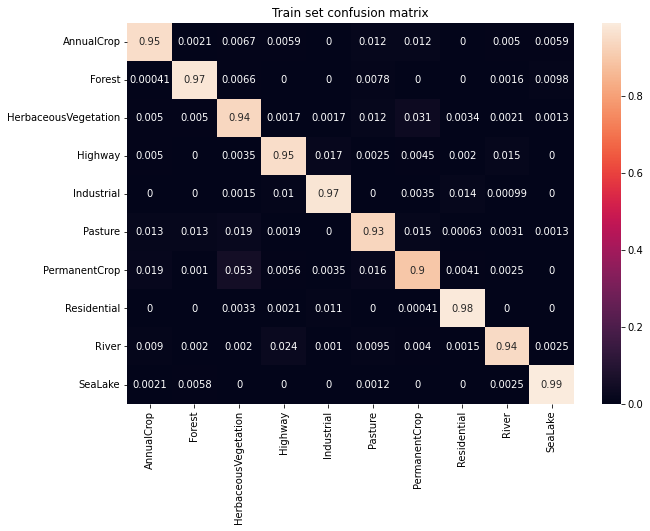

In [6]:
nb_classes = 10

train_images_num = [0 for i in range(10)]

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(train_dl):
        inputs = inputs.to(device)
        classes = classes.to(device)
        for c in classes:
            train_images_num[c] += 1
        outputs = linear_classifier(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

train_classes_accuracy = confusion_matrix.diag()/confusion_matrix.sum(1)
df_cm = pd.DataFrame(confusion_matrix.numpy(), index = [i for i in eurosat_classes], columns=[i for i in eurosat_classes]).round(2)
for i in range(10): df_cm.iloc[i] /= train_images_num[i]
plt.figure(figsize = (10,7))
plt.title("Train set confusion matrix")
sns.heatmap(df_cm, annot=True)

In [21]:
"""
Calculate trainset generalization:
    SUM #P_ilog(1/P_i) * #CCI in class i
G = -------------------------------------------
                    MEC
"""

G_train = 0
shannon_entropy = 0
for i, cls_acc in enumerate(train_classes_accuracy):
    pi = train_images_num[i]/sum(train_images_num)
    shannon_entropy += (pi * np.log2(1/pi))

for i, cls_acc in enumerate(train_classes_accuracy):
    G_train += shannon_entropy*train_images_num[i]*cls_acc
G_train /= 4412


print("Generalization for training set is ", G_train.item(),"[bits]/[bit]")

Generalization for training set is  15.467290878295898 [bits]/[bit]


<AxesSubplot:title={'center':'Test set confusion matrix'}>

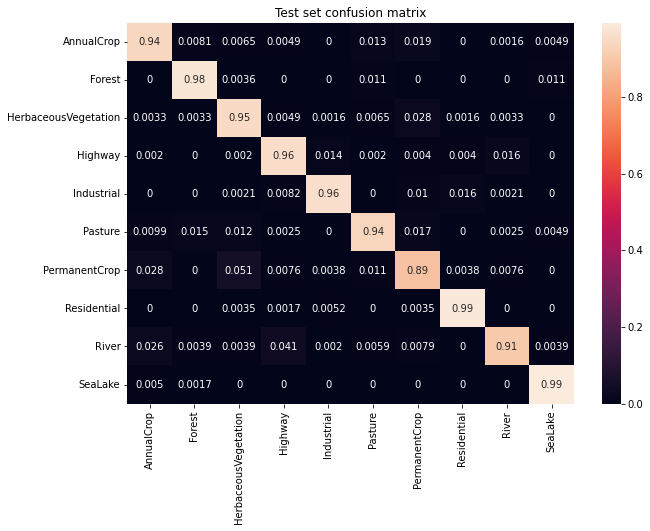

In [11]:
test_images_num = [0 for i in range(10)]

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(test_dl):
        inputs = inputs.to(device)
        classes = classes.to(device)
        for c in classes:
            test_images_num[c] += 1
        outputs = linear_classifier(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

test_classes_accuracy = confusion_matrix.diag()/confusion_matrix.sum(1)
df_cm = pd.DataFrame(confusion_matrix.numpy(), index = [i for i in eurosat_classes], columns=[i for i in eurosat_classes]).round(2)
for i in range(10): df_cm.iloc[i] /= test_images_num[i]
plt.figure(figsize = (10,7))
plt.title("Test set confusion matrix")
sns.heatmap(df_cm, annot=True)
